Author: Adam Szczepaniak

Date: 2025-01-04

**Abalone age prediction**- Predicting the age of abalone from physical measurements.

This project has been made during Polish-Japanese Academy of Information Technology postgraduate studies

# Imports

In [1]:
#ignore warnings
import warnings
warnings.simplefilter ('ignore')

#trans libs
import pandas as pd
import numpy as np
import tensorflow as tf

#visualisation libs
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#ML libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

#setup pandas
pd.set_option ('display.width',100)
pd.set_option ('display.max_rows',50)
pd.set_option ('display.max_columns',20)

#setup seaborn
sns.set_style ('whitegrid')
sns.set_context ('paper', font_scale = 1.1)

#setup matplotlib
mpl.rcParams['font.family'] ='serif'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'semibold'

# 1. Read Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Abalone/abalone.csv')
dfc = df.copy()
dfc

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Height > 0.5 rows dropping

According to Project instructions, rows with "Height" value higher than 0.5, should be dropped.

In [3]:
dfc = dfc.loc[dfc['Height'] <= 0.5]
dfc.shape

(4175, 9)

In effect, 2 rows of dataset has been removed.

## Dataset column names renaming

Space " " in column names will be replaced with underscore "_".

In [4]:
dfc = dfc.rename(columns = {'Whole weight':'Whole_weight', 'Shucked weight':'Shucked_weight', \
                            'Viscera weight':'Viscera_weight', 'Shell weight':'Shell_weight'})
dfc.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight',
       'Shell_weight', 'Rings'],
      dtype='object')

# 2. First sight of data

## Information about dataset

In [5]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4175 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4175 non-null   object 
 1   Length          4175 non-null   float64
 2   Diameter        4175 non-null   float64
 3   Height          4175 non-null   float64
 4   Whole_weight    4175 non-null   float64
 5   Shucked_weight  4175 non-null   float64
 6   Viscera_weight  4175 non-null   float64
 7   Shell_weight    4175 non-null   float64
 8   Rings           4175 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 326.2+ KB


### Empty values check

In [6]:
dfc.isnull().any()

,0
Sex,False
Length,False
Diameter,False
Height,False
Whole_weight,False
Shucked_weight,False
Viscera_weight,False
Shell_weight,False
Rings,False


There are no empty values in dataset.

### Duplicates check

In [7]:
f"Duplicates amount: {dfc.duplicated().sum()}"

'Duplicates amount: 0'

### Numerical data information

In [8]:
dfc.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.523965,0.407856,0.139189,0.828468,0.359195,0.180536,0.238791,9.934132
std,0.120084,0.099230,0.038489,0.490027,0.221713,0.109534,0.139162,3.224802
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093250,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.501750,0.252750,0.328750,11.000000
max,0.815000,0.650000,0.250000,2.825500,1.488000,0.760000,1.005000,29.000000


### Categorical data information

In [9]:
cat_stats = dfc.describe (exclude = np.number)
cat_stats.loc ['top %'] = np.round ((cat_stats.loc['freq'] / cat_stats.loc['count']).astype('float64'),4)
cat_stats

,Sex
count,4175
unique,3
top,M
freq,1527
top %,0.3657


In [10]:
dfc['Sex'].value_counts()

,count
Sex,
M,1527
I,1342
F,1306


## Data description

**Dataset description:**

The dataset consists of 4175 rows and 9 columns. There are seven columns with "float64" data type, one column with "int64" data type, and one column with "object" data type. There are no empty values or duplicates in the dataset.

**Column description:**

**Sex**- Categorical nominal data representing the gender of the abalone. The column contains three possible values: "M" (Male), "F" (Female), "I" (Infant). The most frequent value is "M" with 1527 entries. The data type is "object". The column needs to be encoded.

**Length**- Quantitative continous data representing the longest measurement of the abalone shell, measured in millimeters. The value range from 0.075 mm to 0.815 mm. The data type is "float64".

**Diameter**- Quantitative continous data representing the measurement of the abalone shell, perpendicular to it's length,  measured in millimeters. The value range is from 0.055 mm to 0.650 mm. The data type is "float64".

**Height**- Quantitative continous data representing the height of the abalone shell, measured in millimeters. The value range is from 0.000 mm to 0.250 mm. The minimum value = 0.000 mm seems to be incorrect. The data type is "float64".

**Whole_weight**- Quantitative continous data representing the total weight of the abalone, encompassing both the meat and the shell, measured in grams. The value range is from 0.002 g to 2.8255 g. The data type is "float64".

**Shucked_weight**- Quantitative continous data representing the weight of the abalone meat only, measured in grams. The value range is from 0.001 g to 1.488 g. The data type is "float64".

**Viscera_weight**- Quantitative continous data representing the weight of the abalone gut after bleeding, measured in grams. It provides insights into the weight of the internal organs of the abalone. The value range is from 0.0005 g to 0.760 g. The data type is "float64".

**Shell_weight**- Quantitative continous data representing the weight of the abalone shell only, excluding the meat. It is measured in grams. The value range is from 0.0015 g to 1.005 g. The data type is "float64".

**Rings**-  Quantitative integer data representing the number of rings present on the abalone shell. Number of rings +1.5 gives the abalone age in years (TARGET). The value range is from 1 to 29. The data type is "int64".

## Summary

1. There are values = 0 in "Height" column, which has to be analised.
2. The "Age" column should be calculated as the sum of number of Rings and 1.5,  and added to dataset. After that, "Rings" column should be removed as unnecesary.

In [11]:
dfc.loc[dfc['Height'] == 0]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


There are only two rows with "Height" = 0. Because of fact, that these two rows is only  0.047 percent of the dataset, it may be removed. It should be noticed, that in row 3996 "Whole_weight" value is much smaller than sum of "Shucked_weight", "Viscera_weight" and "Shell_weight", what also seems to be incorrect. We'll try to find out, if there are other rows with incorrect values.

In [12]:
dfc = dfc.loc[dfc['Height'] > 0]

In [13]:
dfc['Age'] = dfc['Rings'] + 1.5
dfc.drop(columns = 'Rings', inplace = True)
dfc['Age'] = dfc['Age'].astype('int64')

In [14]:
dfc['Age'].describe()

,Age
count,4173.000000
mean,10.935538
std,3.224861
min,2.000000
25%,9.000000
50%,10.000000
75%,12.000000
max,30.000000


**Age**- Quantitative continous data representing the age of the abalone, meassured in years. The value range is from 2.5 to 30.5. The data type is "int64".

In [15]:
dfc['Weight_diff'] = dfc['Whole_weight'] - (dfc['Shucked_weight'] + dfc['Viscera_weight'] + dfc['Shell_weight'])
dfc.loc[dfc['Weight_diff'] < 0]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age,Weight_diff
42,I,0.240,0.175,0.045,0.0700,0.0315,0.0235,0.0200,6,-0.0050
43,I,0.205,0.150,0.055,0.0420,0.0255,0.0150,0.0120,6,-0.0105
44,I,0.210,0.150,0.050,0.0420,0.0175,0.0125,0.0150,5,-0.0030
45,I,0.390,0.295,0.095,0.2030,0.0875,0.0450,0.0750,8,-0.0045
46,M,0.470,0.370,0.120,0.5795,0.2930,0.2270,0.1400,10,-0.0805
...,...,...,...,...,...,...,...,...,...,...
3885,I,0.410,0.330,0.105,0.3350,0.1525,0.0740,0.1100,8,-0.0015
3963,I,0.270,0.205,0.075,0.1180,0.0590,0.0310,0.0305,5,-0.0025
3969,I,0.380,0.300,0.090,0.2770,0.1655,0.0625,0.0820,7,-0.0330
4046,M,0.600,0.460,0.155,0.6655,0.2850,0.1490,0.2690,12,-0.0375


In [16]:
weight_minus = dfc['Weight_diff'].loc[dfc['Weight_diff'] < 0]
weight_minus.min(), weight_minus.max()

(-0.4475, -6.938893903907228e-18)

It seems, that there are 154 rows with potentially incorrect weight values, with range between -0.4475 and close to 0, which represents 3.7 % of the dataset.

In [17]:
dfc = dfc.loc[dfc['Weight_diff'] >= 0]
dfc.drop(columns = 'Weight_diff', inplace = True)

# 3. Model Implementation

## Entry dataset (X) and target vector (y) creation

In [18]:
# Creating entry dataset:

X = dfc.iloc[:,:-1]

# Creating target dataset:

y = dfc.iloc[:,-1]
X, y

(     Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  Shell_weight
 0      M   0.455     0.365   0.095        0.5140          0.2245          0.1010        0.1500
 1      M   0.350     0.265   0.090        0.2255          0.0995          0.0485        0.0700
 2      F   0.530     0.420   0.135        0.6770          0.2565          0.1415        0.2100
 3      M   0.440     0.365   0.125        0.5160          0.2155          0.1140        0.1550
 4      I   0.330     0.255   0.080        0.2050          0.0895          0.0395        0.0550
 ...   ..     ...       ...     ...           ...             ...             ...           ...
 4172   F   0.565     0.450   0.165        0.8870          0.3700          0.2390        0.2490
 4173   M   0.590     0.440   0.135        0.9660          0.4390          0.2145        0.2605
 4174   M   0.600     0.475   0.205        1.1760          0.5255          0.2875        0.3080
 4175   F   0.625     0.485   0.150     

## Training and test sets creation

To avoid data leaks, it is necessary to create training and test sets before scaling:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3215, 8), (804, 8), (3215,), (804,))

## Data scaling and encoding

 Most of the columns, except 'Sex' column, will be scaled with RobustScaler, which is less sensitive to outliers. The 'Sex' column will be encoded with one-hot method.

In [20]:
X_train_sc = pd.get_dummies(X_train, columns = ['Sex'])
rbsc = RobustScaler()
X_train_sc[['Length','Diameter','Height','Whole_weight','Shucked_weight',\
   'Viscera_weight','Shell_weight']] = rbsc.fit_transform(X_train [['Length','Diameter',\
                                                             'Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight']])

X_test_sc = pd.get_dummies(X_test, columns = ['Sex'])
X_test_sc[['Length','Diameter','Height','Whole_weight','Shucked_weight',\
   'Viscera_weight','Shell_weight']] = rbsc.fit_transform(X_test [['Length','Diameter',\
                                                             'Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight']])

X_train_sc = X_train_sc.astype('float64')
X_test_sc = X_test_sc.astype('float64')

Target vector will be scaled with StandardScaler:

In [21]:
sc = StandardScaler()
y_train_sc = sc.fit_transform(y_train.to_frame())
y_train_sc = pd.Series(y_train_sc.flatten())

y_test_sc = sc.fit_transform(y_test.to_frame())
y_test_sc = pd.Series(y_test_sc.flatten())

## Sequential model creation

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_dim = 10, activation = 'sigmoid', name = 'Input'),
    tf.keras.layers.Dense(4, activation = 'sigmoid', name = 'Middle'),
    tf.keras.layers.Dense(1, activation = 'linear', name = 'Output')
])

## Model compilation

In [23]:
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = [tf.keras.metrics.R2Score()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (Dense)                        │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Middle (Dense)                       │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249 (996.00 B)

 Trainable params: 249 (996.00 B)

 Non-trainable params: 0 (0.00 B)

## Model fitting

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping (monitor = 'val_loss', patience = 10, restore_best_weights=True)

fit = model.fit(X_train_sc, y_train_sc, epochs = 800, verbose = 'auto',
                validation_data = (X_test_sc, y_test_sc), batch_size = 24, shuffle = True,
                callbacks = [early_stopping])

Epoch 1/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.9882 - r2_score: -0.0472 - val_loss: 0.9195 - val_r2_score: 0.0805
Epoch 2/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8802 - r2_score: 0.0803 - val_loss: 0.8169 - val_r2_score: 0.1831
Epoch 3/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8306 - r2_score: 0.1776 - val_loss: 0.7519 - val_r2_score: 0.2481
Epoch 4/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7525 - r2_score: 0.2141 - val_loss: 0.7080 - val_r2_score: 0.2920
Epoch 5/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7582 - r2_score: 0.2572 - val_loss: 0.6775 - val_r2_score: 0.3225
Epoch 6/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6912 - r2_score: 0.2916 - val_loss: 0.6512 - val_r2_score: 0.3488
Epoch 7/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6891 - r2_score: 0.3145 - val_loss: 0.6287 - val_r2_score: 0.3713
Epoch 8/800
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6746 - r2_score: 0.3232 - val_lo

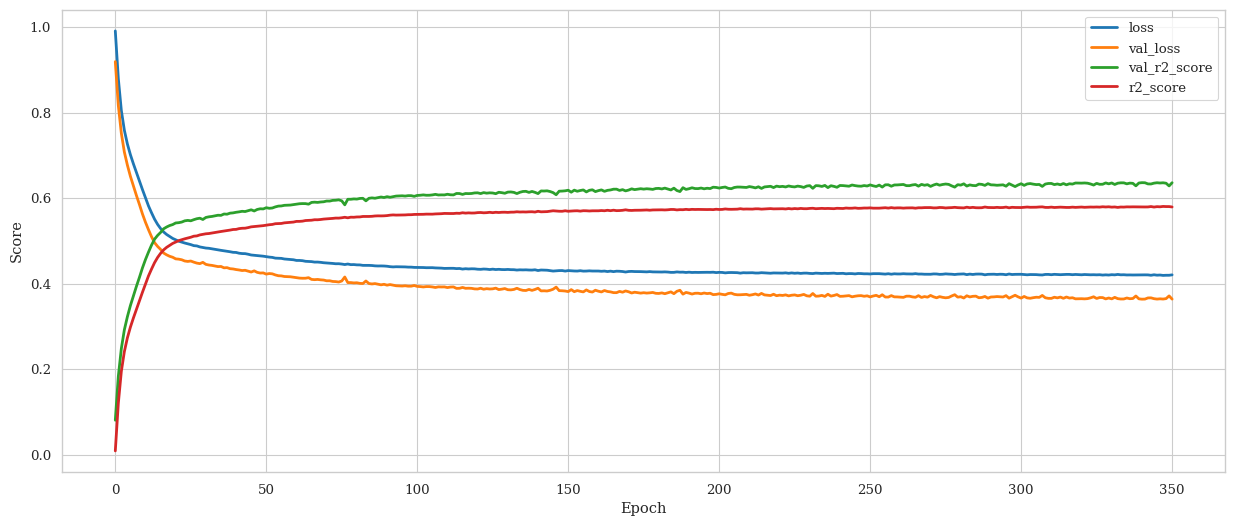

In [25]:
plt.figure(figsize = (15, 6))

plt.plot(fit.history['loss'], '-', label = 'loss')
plt.plot(fit.history['val_loss'], '-', label = 'val_loss')
plt.plot(fit.history['val_r2_score'], '-', label = 'val_r2_score')
plt.plot(fit.history['r2_score'], '-', label = 'r2_score')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Model prediction

Model evaluation:

In [26]:
model.evaluate(X_train_sc, y_train_sc, batch_size = 24), model.evaluate(X_test_sc, y_test_sc, batch_size = 24)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4213 - r2_score: 0.5630
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3355 - r2_score: 0.6457


([0.41864755749702454, 0.5813524723052979],
 [0.363714337348938, 0.636285662651062])

Scaling inversion of train and test target vector:

In [27]:
y_train_inv = sc.inverse_transform(y_train_sc.to_frame())
y_test_inv = sc.inverse_transform(y_test_sc.to_frame())

Model prediction:

In [28]:
y_train_sc_pred = model.predict(X_train_sc)
y_test_sc_pred = model.predict(X_test_sc)

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Scaling inversion of predicted target values:

In [29]:
y_train_pred = sc.inverse_transform(y_train_sc_pred).astype('int64')
y_test_pred = sc.inverse_transform(y_test_sc_pred).astype('int64')

# Visualization of model results

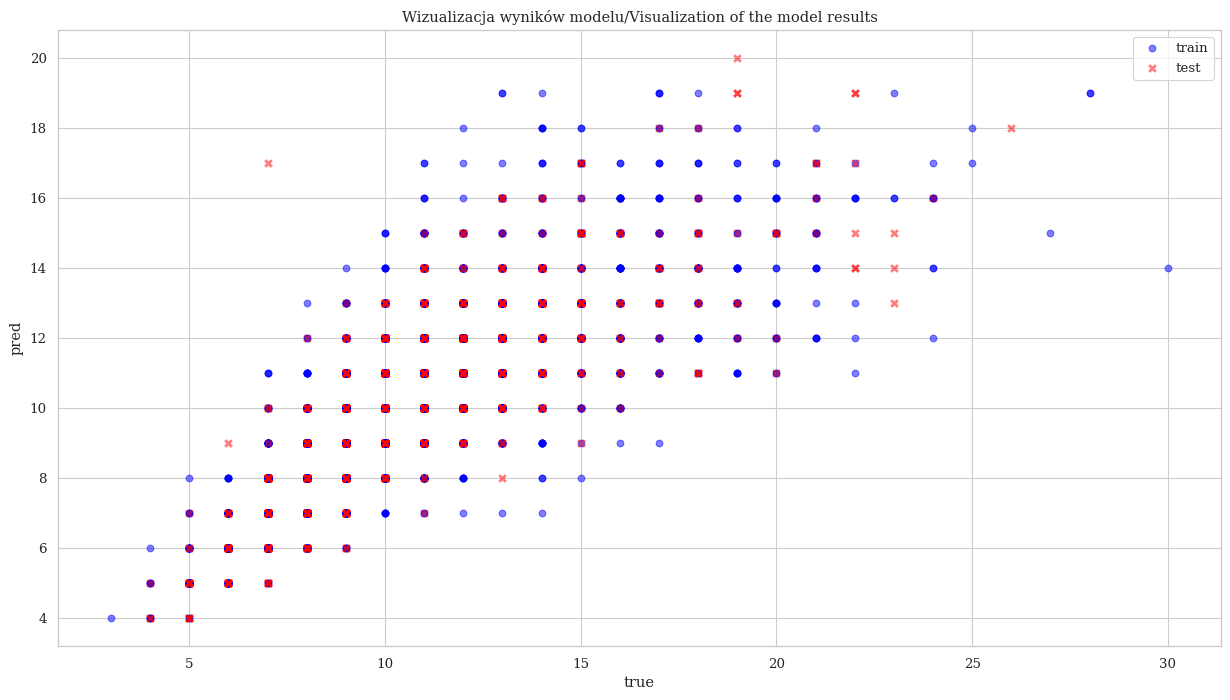

In [30]:
plt.figure(figsize=(15, 8))

plt.scatter(y_train, y_train_pred, color='blue', label='train', alpha=0.5)
plt.scatter(y_test, y_test_pred, color='red', marker='x', label='test', alpha=0.5)

plt.xlabel('true')
plt.ylabel('pred')

plt.title('Wizualizacja wyników modelu/Visualization of the model results')

plt.legend()

plt.show()

# Calculation of the MSE and the R2 metrics

In [31]:
# Train data metrics

mse_train = round(mean_squared_error(y_train, y_train_pred), 4)
r2_train = round(r2_score(y_train, y_train_pred), 4)

# Test data metrics

mse_test = round(mean_squared_error(y_test, y_test_pred), 4)
r2_test = round(r2_score(y_test, y_test_pred), 4)


metrics = pd.DataFrame({'MSE': [mse_train, mse_test],
                        'R2': [r2_train, r2_test]},
                       index = ['Train', 'Test'])
metrics

,MSE,R2
Train,4.7919,0.5367
Test,4.1169,0.6083


# Summary

The model with R2 score between 0.54-0.61 shows rather average performace. It may be influenced by factors such as the presence of outliers, which were not analized in this task. The better fit on the test data (lower MSE, higher R2 score) suggests, that the model generalizes better and may perform better with new, unseen data.

There is a potential for model improvement, such as detecting outliers or transforming the data before model creation. Additionally, modifying the neural network architecture or tuning hyperparameters could further enhance the model's performance.